# Siamese Network

This notebook explores creating a Siamese Network with a triplet-loss function to attempt to differentiate the images.

To do:

1. Build a Dataset that returns a single triplet of images.
2. Build a Dataloader for it too.
3. Construct a loss function.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from PIL import Image
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import optim 
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torchvision import models
from torch import nn

from matplotlib import pyplot as plt

In [2]:
def ceildiv(a, b):
    return -(-a // b)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, maintitle=None):
    """Function for plotting a bunch of images from fastai."""
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3): ims = ims.transpose((0,2,3,1))
    if type(ims[0]) is torch.FloatTensor:
        ims = [i.permute(1,2,0) for i in ims]

    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, ceildiv(len(ims), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
class TripletFolder(ImageFolder):
    
    """
    Modification of ImageFolder.
    
    Return a triplet of images each iteration:

      1. anchor (the image at id).
      2. positive (an image from the same class as the anchor).
      3. negative (an image from a different class as the anchor).
    """

    def __init__(self, *args, **kwargs):
        super(TripletFolder, self).__init__(*args, **kwargs)
        
        self.class_to_imgs = defaultdict(list)
        for (path, class_id) in self.imgs:
            self.class_to_imgs[class_id].append(path)
            
        class_sizes = np.array([len(self.class_to_imgs[self.class_to_idx[c]]) for c in self.classes])
        self.class_weights = class_sizes / np.sum(class_sizes)

    def __getitem__(self, idx):
        anchor_path, target = self.imgs[idx]
        anchor_img = self.loader(anchor_path)
        
        other_imgs = self.class_to_imgs[target]
        positive_path = np.random.choice(other_imgs, 1)[0]
        positive_img = self.loader(positive_path)
    
        # Get a negative example, ensuring it's not from the class.
        negative_img = None
        while negative_img is None:
            other_class = np.random.choice(self.classes, 1, p=self.class_weights)[0]
            other_target = self.class_to_idx[other_class]
        
            if other_target == target:
                continue

            imgs = self.class_to_imgs[other_target]
            negative_path = np.random.choice(imgs, 1)[0]
            negative_img = self.loader(negative_path)
                
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
    
        # Return a tuple of anchor, positive, negative
        return (anchor_img, positive_img, negative_img), []

In [20]:
transform = [
    transforms.RandomRotation(8),
    transforms.ColorJitter(0.01, 0.01, 0.01),
    transforms.RandomGrayscale(p=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]

In [21]:
dataset_test = TripletFolder('./data/prepared/340/train/', transform=transforms.Compose(transform))

CPU times: user 376 ms, sys: 12 ms, total: 388 ms
Wall time: 65.7 ms


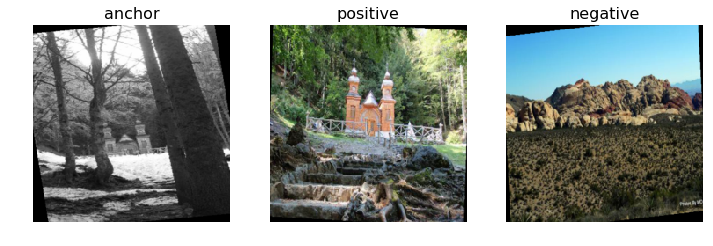

In [22]:
%time plots(dataset_test[0][0], titles=['anchor', 'positive', 'negative'])

CPU times: user 1.41 s, sys: 64 ms, total: 1.48 s
Wall time: 189 ms


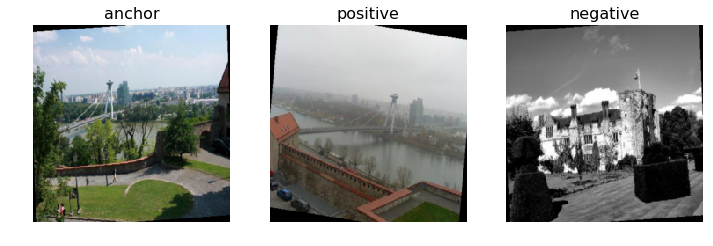

In [23]:
%time plots(dataset_test[500][0], titles=['anchor', 'positive', 'negative'])

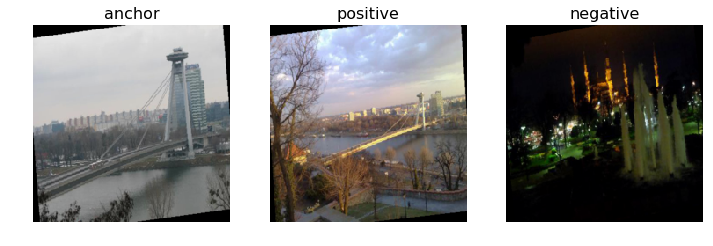

In [24]:
plots(dataset_test[1000][0], titles=['anchor', 'positive', 'negative'])

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = [
    transforms.RandomRotation(8),
    transforms.ColorJitter(0.01, 0.01, 0.01),
    transforms.RandomGrayscale(p=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]

val_transform = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]

In [5]:
latent_dim = 128

Want to load ResNet50, then replace the final layers with a fully-connected layer with some number of latent factors.

In [6]:
class SiameseNet(nn.Module):
    
    def __init__(self):
        super(SiameseNet, self).__init__()
        
        self.base_model = models.resnet34(pretrained=True)
        
        #for param in self.base_model.parameters():
        #    param.requires_grad = False
    
        self.base_model.fc = nn.Linear(
            self.base_model.fc.in_features, latent_dim)
        
    def forward(self, anchor, primary, negative):
        anchor_out = self.base_model(anchor)
        primary_out = self.base_model(primary)
        negative_out = self.base_model(negative)
        
        return (anchor_out, primary_out, negative_out)

In [36]:
model = SiameseNet()
bs = 32
model = model.cuda()
max_steps = 1000

dataset = TripletFolder(
    './data/prepared/340/train/', transform=transforms.Compose(transform))
dl = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=8)

val_dataset = TripletFolder(
    './data/prepared/340/val/', transform=transforms.Compose(val_transform))
val_dl = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=8)

lr = 0.00001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

for epoch in range(5):
    
    model.train()
    
    running_loss = 0.0
    t = tqdm(enumerate(dl), total=min(len(dl), max_steps))
    for batch_idx, (data, target) in t: 
        anchors_in, positives_in, negatives_in = data
        
        optimizer.zero_grad()

        anchors_out, positives_out, negatives_out = model(
            Variable(anchors_in.cuda()),
            Variable(positives_in.cuda()),
            Variable(negatives_in.cuda()))

        loss = nn.functional.triplet_margin_loss(anchors_out, positives_out, negatives_out)

        loss.backward()

        optimizer.step()

        # print stats
        running_loss += loss.data[0]
        if (batch_idx + 1) % 100 == 0:
            avg_loss = running_loss / (batch_idx + 1)
            t.set_description(f'[{avg_loss}]')
        
        if (batch_idx + 1) >= max_steps:
            avg_loss = running_loss / (batch_idx + 1)
            print(f"Final loss: {avg_loss}")
            break
    
    model.eval()
    
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(val_dl):
        anchors_in, positives_in, negatives_in = data
        anchors_out, positives_out, negatives_out = model(
            Variable(anchors_in.cuda()),
            Variable(positives_in.cuda()),
            Variable(negatives_in.cuda()))

        loss = nn.functional.triplet_margin_loss(anchors_out, positives_out, negatives_out)
        
        running_loss += loss.data[0]
        
        if (batch_idx + 1) >= 100:
            break
        
    avg_loss = running_loss / (batch_idx + 1)
        
    print(f"Val loss {avg_loss}")


Final loss: 0.293047349691391
Val loss 0.2175956356525421



Final loss: 0.18178136360645294
Val loss 0.194045073390007



Final loss: 0.15128846144676208
Val loss 0.17744009494781493



Final loss: 0.13969202774763106
Val loss 0.18386182948946952



Final loss: 0.12378948339819908
Val loss 0.14896347880363464


* To do: learn how to save and load a model.
* Put training code into function.
* Generate predictions for the validation data.
* Create a nearest neighbours representation and explore validation set.

In [37]:
torch.save(model, f'data/models/resnet34_v1.model')

/home/lex/anaconda3/envs/landmark-recognition-challenge/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [7]:
model = torch.load(f'data/models/resnet34_v1.model')

In [8]:
def denorm_img(img):
    return np.clip(
        img.numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

In [9]:
inference_model = model.base_model
model = None

In [59]:
# Iterate through each image in the validation set and create a prediction for each.
data = ImageFolder(root='./data/prepared/340/train/', transform=transforms.Compose(val_transform))

In [13]:
img, img_class = data[0]

Img class 0


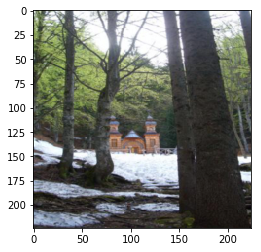

In [16]:
print(f'Img class {img_class}')
plt.imshow(denorm_img(img))

In [17]:
anchor = inference_model(Variable(img.unsqueeze(0)).cuda())

Img class 0


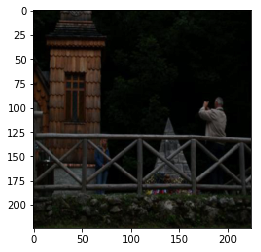

In [24]:
print(f'Img class {img_class}')
plt.imshow(denorm_img(img))

In [22]:
positive_1 = inference_model(Variable(img.unsqueeze(0)).cuda())

In [23]:
nn.functional.pairwise_distance(anchor, positive_1)

Variable containing:
 7.2288
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [25]:
img, img_class = data[2]

Img class 0


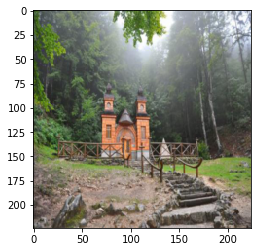

In [26]:
print(f'Img class {img_class}')
plt.imshow(denorm_img(img))

In [27]:
positive_2 = inference_model(Variable(img.unsqueeze(0)).cuda())

In [28]:
nn.functional.pairwise_distance(anchor, positive_2)

Variable containing:
 6.5053
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [29]:
nn.functional.pairwise_distance(positive_1, positive_2)

Variable containing:
 7.6981
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Img class 207


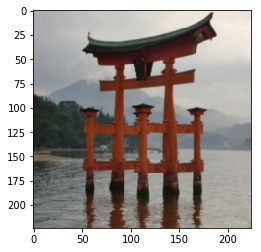

In [30]:
img, img_class = data[20000]
print(f'Img class {img_class}')
plt.imshow(denorm_img(img))

In [31]:
negative = inference_model(Variable(img.unsqueeze(0)).cuda())

In [32]:
nn.functional.pairwise_distance(anchor, negative)

Variable containing:
 10.1384
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [33]:
nn.functional.pairwise_distance(positive_1, negative)

Variable containing:
 8.3618
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [34]:
nn.functional.pairwise_distance(positive_2, negative)

Variable containing:
 11.3182
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Img class 316


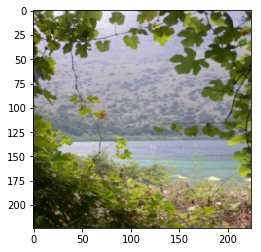

In [35]:
img, img_class = data[30000]
print(f'Img class {img_class}')
plt.imshow(denorm_img(img))

In [37]:
nn.functional.pairwise_distance(anchor, negative_2)

Variable containing:
 7.0763
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [43]:
nn.functional.pairwise_distance(negative, negative_2)

Variable containing:
 9.2151
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

Img class 477


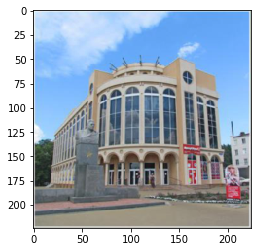

In [44]:
img, img_class = data[40000]
print(f'Img class {img_class}')
plt.imshow(denorm_img(img))

In [45]:
negative_3 = inference_model(Variable(img.unsqueeze(0)).cuda())

In [46]:
nn.functional.pairwise_distance(anchor, negative_3)

Variable containing:
 9.7744
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [10]:
val_data = ImageFolder(root='./data/prepared/340/val/', transform=transforms.Compose(val_transform))

In [13]:
val_dl = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=8)

In [14]:
encodings = []
landmark_ids = []

for imgs, targets in tqdm(val_dl, total=len(val_dl)):
    preds = inference_model(Variable(imgs).cuda())
    for p, t in zip(preds.data, targets):
        encodings.append(p)
        landmark_ids.append(t)

In [28]:
enc = np.array([e.cpu().numpy() for e in encodings])

In [30]:
landmark_ids = np.array(landmark_ids)

In [31]:
enc.shape

(461190, 128)

In [32]:
landmark_ids.shape

(461190,)

In [33]:
np.save('./data/pickle/encodings', enc)

In [34]:
np.save('./data/pickle/landmark_ids', landmark_ids)

In [35]:
encodings = np.load('./data/pickle/encodings.npy')

In [36]:
landmark_ids = np.load('./data/pickle/landmark_ids.npy')

In [37]:
encodings.shape

(461190, 128)

In [38]:
landmark_ids.shape

(461190,)